In [1]:
%matplotlib inline
from netCDF4 import Dataset
from pylab import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=False)
sns.reset_orig()

matplotlib.rcParams['lines.linewidth'] = 0.6

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['axes.facecolor'] = '#F8F8FF'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['axes.labelsize'] = 7

matplotlib.rcParams['grid.linestyle'] = '-.'
matplotlib.rcParams['grid.linewidth'] = 0.4

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 0.7

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 0.7

In [2]:
from scipy.ndimage.filters import uniform_filter1d

def martians_month(ls, data):
    temp = []
    for i in np.arange(0, 12):
        idx = np.where((ls>i*30)&(ls<(i+1)*30))[0]
        temp.append(data[idx].mean(axis=0))
    temp = np.array(temp)
    return temp

def martians_year(ls, data):
    #### only looking at "second year"
    idx = np.where(ls==360)[0]
    if idx[0] != 0 and idx.size > 1:
        idx0 = idx[0]
        idx1 = idx[1]
        return data[idx0:idx1]
    elif idx[0] != 0 and idx.size == 1:
        idx1 = idx[0]
        return data[:idx1]
    elif idx[0] == 0:
        idx1 = idx[1]
        idx2 = idx[2]
        return data[idx1:idx2]

def window_stdev(arr, radius):
    #array = arr, radius = half width of window in bins
    #windows mean
    c1 = uniform_filter1d(arr, 2*radius, mode='constant', origin=-radius,axis=0)
    #windowed square mean
    c2 = uniform_filter1d(arr*arr, 2*radius, mode='constant', origin=-radius,axis=0)
    #std = windowed square mean - square(windowed mean)
    return ((c2 - c1*c1)**.5)[:-2*radius+1]

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5,axis=0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data,axis=axis)
    return y

3it [00:29,  9.65s/it]


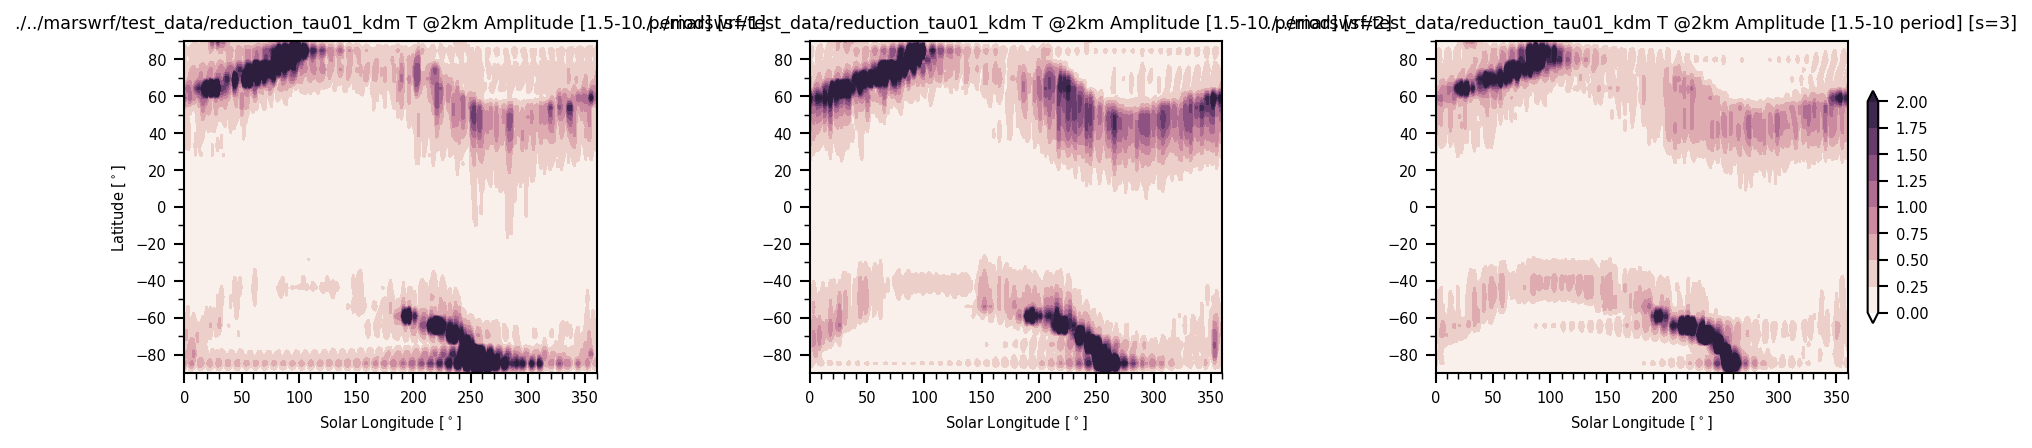

In [27]:
from matplotlib.backends.backend_pdf import PdfPages

def spect_v(ls, data, tstep, lonstep, lowcut, highcut, wave):
    lowcut = 1./lowcut
    highcut = 1./highcut
        
    fftdata = np.fft.fftn(data, axes=[0,2])
    freq = np.fft.fftfreq(fftdata.shape[0], tstep)
    waven = np.fft.fftfreq(fftdata.shape[2], lonstep)*360
    
    idx1 = np.where((abs(freq)>lowcut)|(abs(freq)<highcut))[0]
#     print (idx1, waven)
    
#     set everything that satisfy condition as zero, ie only filtering storm system
    fftdata[idx1] = 0
    if wave == 0:
        wave1_idx= np.where(((waven)!=wave))[0]
        fftdata[:,:,wave1_idx] = 0
    elif wave:
        wave1_idx= np.where(((waven)!=wave))[0]
        fftdata[:,:,wave1_idx] = 0
        fftdata = fftdata*2
    else:
        pass

    filtered = np.fft.ifftn(fftdata, axes=[0,2])
    filtered = np.abs(filtered)**2

    temp = filtered.mean(axis=2)
    return np.sqrt(temp)

def T2km_filter_waven(directory):
    directory1 = directory+"/wrfout_T2KM.npy"
    directory2 = directory+"/wrfout_ls_PSFC.npy"
    psfc = np.load(directory1)
    ls = np.load(directory2)

    wave = [-1,2,3]
    psfc = martians_year(ls, psfc)
    ls = martians_year(ls, ls)

    title = directory.replace('./../marswrf/test_data/reduction_diag.','')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3), sharex=True)
    for i, ax in tqdm(enumerate(axes.flat)):
        tst = spect_v(ls, psfc,  1/8., 5., 1.5, 10., wave[i])

        im = ax.contourf(np.linspace(0,360, 223), np.linspace(-90,90,36), tst.T.reshape((36,223,24)).mean(axis=2), np.linspace(0,2,9), extend='both', cmap = cmap)
        for c in im.collections:
                c.set_edgecolor("face")
                
        ax.set_title('{} T @2km Amplitude [1.5-10 period] [s={}]'.format(title, i+1))
        if i+1 in [1]:
            ax.set_ylabel('Latitude [$^\circ$]')
        ax.set_xlabel('Solar Longitude [$^\circ$]')
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    fig.tight_layout()
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, orientation='vertical', pad=0.01)
#     plt.savefig(pdFigures,  format='pdf', bbox_inches='tight', dpi=400)

    
with PdfPages('T2km_filter_waven_2.pdf') as pdFigures:
#     T2km_filter_waven("./../marswrf/test_data/reduction_diag.r14p1dustL40")
    T2km_filter_waven("./../marswrf/test_data/reduction_tau01_kdm")

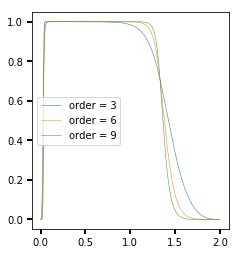

In [3]:
fs = 4.
lowcut = 1./30
highcut = 1./.75

plt.figure(figsize=(12,4))
subplot(131)
for order in [3,6,9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
plt.legend()
plt.show()

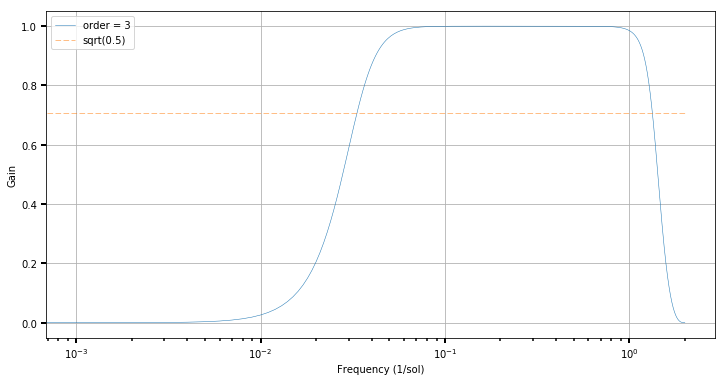

In [4]:
plt.figure(figsize=(12,6))
for order in [3]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    
plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (1/sol)')
plt.ylabel('Gain')
plt.xscale('log')
plt.grid(True)
plt.legend(loc='best')
plt.show()


[  87 5439]
(5352, 36, 72) 5352


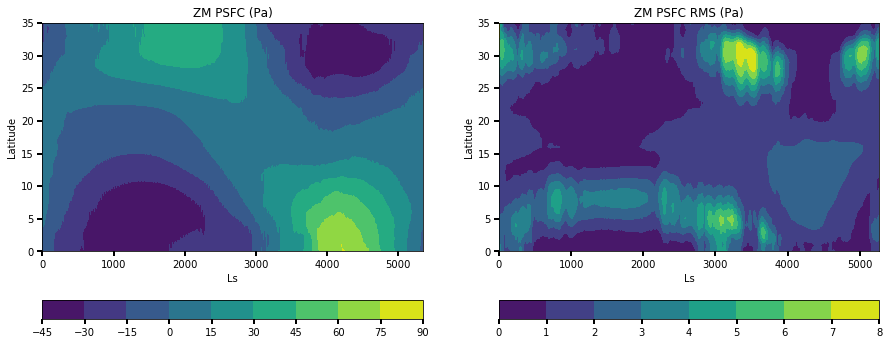

In [5]:
directory1="./../marswrf/test_data/reduction_diag.r14p1dustL40/wrfout_T2KM.npy"
directory2="./../marswrf/test_data/reduction_diag.r14p1dustL40/wrfout_ls_PSFC.npy"
psfc = np.load(directory1)
ls = np.load(directory2)

idx = np.where(ls==360)[0]
print (idx)
psfc = psfc[idx[0]:idx[-1]]
psfc = psfc - np.mean(psfc,axis=0)
ls = ls[idx[0]:idx[-1]]

fs = 8.
lowcut = 1./30
highcut = 1./1.5

y = butter_bandpass_filter(psfc, lowcut, highcut, fs, order=4, axis=0)
ly=len(y)
print (y.shape, ly)
#dy = window_stdev(y, ly)

wlen=1+20/0.25
dy=zeros_like(y)
ly=len(y)
#for i in (range(len(y))):
    #dy[i] = window_stdev(y[i], int(wlen/2))
#    l=clip(i-wlen/2,0,ly)
#    h=clip(i+wlen/2,0,ly)
#    print (window_stdev(y[l:h], int(wlen/2)))
dy = window_stdev(y, int(wlen/2))
    
#    dy[i]=var(y[l:h],axis=0)

plt.figure(figsize=(15,6))
lat = np.linspace(-90,90,36)
#w=slice(100,None)
plt.subplot(1,2,1)
contourf(mean(psfc,axis=2).T)
ylabel("Latitude") 
xlabel("Ls")
colorbar(orientation='horizontal')
title("ZM PSFC (Pa)")

plt.subplot(1,2,2)
contourf(mean(dy,axis=2).T)
ylabel("Latitude")
xlabel("Ls")
colorbar(orientation='horizontal')
title("ZM PSFC RMS (Pa)")
plt.show()

(5500, 52, 36)
(5352, 52, 11, 72)
0
6
12
18
24
30
36
42
48
(52, 5273, 11)
(52, 5273, 11)


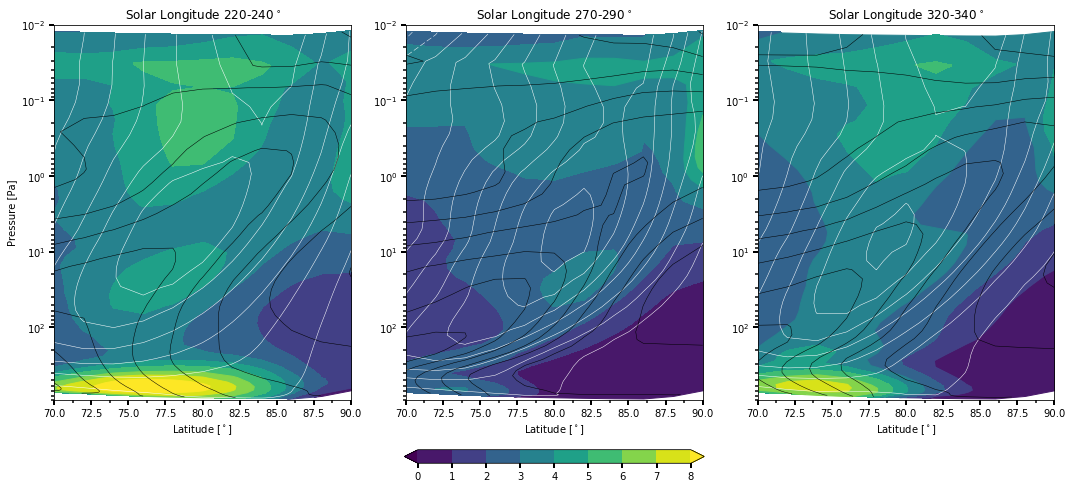

In [7]:
filedir = './../marswrf/test_data/reduction_diag.r14p5/'

def martians_month(ls, data):
    temp = []
    for i in np.arange(0, 12):
        idx = np.where((ls>i*30)&(ls<(i+1)*30))[0]
        temp.append(data[idx].mean(axis=0))
    temp = np.array(temp)
    return temp

def martians_year(ls, data):
    #### only looking at "second year"
    idx = np.where(ls==360)[0]
    if idx[0] != 0 and idx.size > 1:
        idx0 = idx[0]
        idx1 = idx[1]
        return data[idx0:idx1]
    elif idx[0] != 0 and idx.size == 1:
        idx1 = idx[0]
        return data[:idx1]
    elif idx[0] == 0:
        idx1 = idx[1]
        idx2 = idx[2]
        return data[idx1:idx2]
    
def bandpass_filter(filedir):
      
    filepath = glob.glob(filedir + '*_ T.npy')[0]
    T = np.load(filepath)[:,:,:] #2:7
    #fake news
    #T = T * np.broadcast_to(np.exp(-np.arange(52)[np.newaxis,:,np.newaxis,np.newaxis])**0.25,T.shape)
    #T = T.mean(axis=3)
    #T = T - T.mean(axis=0)
    #psfc = psfc - psfc.mean(axis=0)
    
    filepath = glob.glob(filedir + '*LS.npy')[0]
    ls = np.load(filepath)  
    
    filepath = glob.glob(filedir + '*P.npy')[0]
    p = np.load(filepath)
    print (p.shape)
    p = p[:,:,25:].mean(axis=0)
    
    filepath = glob.glob(filedir + '*_U.npy')[0]
    U = np.load(filepath)[:,:,25:]
    
    T = martians_year(ls, T)
    U = martians_year(ls, U)
    print (T.shape)
    ls = martians_year(ls, ls)
    
    wlen = 1+20/0.25
    filtered = []
    for i in np.arange(52):
        if i%6 ==0:
            print (i)
        tmp = T[:,i] - T[:,i].mean(axis=0)
        y = butter_bandpass_filter(tmp , lowcut, highcut, fs, order=4, axis=0)
        dy = (window_stdev(y, int(wlen/2)))
        filtered.append(dy)
    filtered = np.array(filtered).mean(axis=3)
    print (filtered.shape)
    #del T
    
    #print (T.shape)
    
    #T = np.fft.fftshift(np.fft.fftn(T, axes=[0]), axes=[0])
    #c = np.fft.fftshift(np.fft.fftfreq(T.shape[0], 180/1440.))
    #idx = np.where((abs(c)<1.5)|(abs(c)>10))
    
    #T[idx] = 0
    #T = np.abs(np.fft.ifftn(np.fft.ifftshift(T, axes=[0]), axes=[0]))**2
    #T = martians_month(ls, np.sqrt(T))
    
    lat = np.linspace(40,90,11)
    
    dls = np.linspace(0, 360, dy.shape[0])
    press = np.linspace(1e-2,900,52)
    #ls, press = np.meshgrid(dls, press)
    
    period = [220, 270, 320]
    ampl = []
    t = []
    u = []
    dls = np.linspace(0, 360, dy.shape[0])
    ls = np.linspace(0,360,U.shape[0])
    for i in period:
        idx = np.where((dls>i)&(dls<(i+20)))[0]
        tmp = filtered[:,idx].mean(axis=1)
        ampl.append(tmp)
        
        idx2 = np.where((ls>i)&(ls<(i+20)))[0]
        t.append(T[idx2].mean(axis=0).mean(axis=2))
        u.append(U[idx2].mean(axis=0))
        
    lat = np.linspace(70,90,11)
    tmp = np.linspace(1e-2, 900,52)
    lat, tmp = np.meshgrid(lat, tmp)
    print(filtered.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
    for i, ax in enumerate(axes.flat):
        im = ax.contourf(lat, p, ampl[i], levels = np.linspace(0,8,9), cmap='viridis', extend='both')
        for c in im.collections:
                c.set_edgecolor("face")
        ax.contour(lat, p, u[i], np.linspace(-150,150,16), colors='w')
        ax.contour(lat, p, t[i], np.linspace(110,240,14), colors='k')
        ax.set_title('Solar Longitude {}-{}{}'.format(period[i], period[i]+20, '$^\circ$'))

        ax.set_yscale('log')
        ax.set_ylim([900, 1e-2])
        if i in [0]: ax.set_ylabel('Pressure [Pa]')
        ax.set_xlabel('Latitude [$^\circ$]')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))

#    ax.set_title('Bandpass Filter Temperature at 2.5 km')
    fig.tight_layout()
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, orientation='horizontal', pad=0.1)
    plt.savefig('r14p1dustL45_butterworth_t_u_superimposed.pdf',  bbox_inches='tight', dpi=400)
    plt.show()

bandpass_filter(filedir)  


In [7]:
lat = np.linspace(-90,90,36)
np.where(lat>70)
lat[27], lat[31]
ls = np.linspace(0,360,5273)
round(ls[4800])

328.0